In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import enviroment_no_visual as enviroment

Funzioni per inizializzare e accedere la tabella dei Q-Values

In [2]:
def binary_vector_to_decimal(vector):    
    binary_string = ''.join(map(str, vector))
    decimal_value = int(binary_string, 2)
    return decimal_value

# Crea un array con tutte le combinazioni di 0 e 1 di lunghezza n
def generate_boolean_vectors(n):
    return np.array(np.meshgrid(*[np.arange(2)] * n)).T.reshape(-1, n)

def initialize_QValues():
    Q_table = np.zeros((2048, 3))
    all_states = generate_boolean_vectors(11)
    for s in all_states:
        if (s[3] + s[4] + s[5] + s[6]) != 1: # controlla che esista una sola direzione
            impossible_row = binary_vector_to_decimal(s)
            Q_table[impossible_row, :] = -np.inf
        if (s[7] + s[8]) > 1 or (s[9] + s[10]) > 1 or ((s[7] + s[8] + s[9] + s[10]) == 0): # controlla che il frutto non sia a destra e a sinistra o sopra e sotto
            impossible_row = binary_vector_to_decimal(s)
            Q_table[impossible_row, :] = -np.inf
    return Q_table

Exploration policies

In [3]:
def random_policy():
    return np.random.randint(3)

def epsilon_greedy_policy(Q_table, state, epsilon):
    if random.uniform(0,1) < epsilon:
        return np.random.randint(3)
    else:
        row_Q_value = binary_vector_to_decimal(state)
        return np.argmax(Q_table[row_Q_value])

# Q(s,a)<- r+gamma*max( f(Q(s',a'), N(s',a')) ) 
# con N(s',a') che conta il numero di volte che l'azione a' è scleta nello stato s'
# con f(Q,N) la funzione di esplorazione tale che f(Q,N) = Q + k/(1 + N), con k un iperparametro
def exploration_function_policy(Q_table, N_table, state, k):
    row_Q_value = binary_vector_to_decimal(state)
    exploration_values = Q_table[row_Q_value] + k / (1 + N_table[row_Q_value])
    return np.argmax(exploration_values)
def update_N_table(N_table, state, action):
    row_N_value = binary_vector_to_decimal(state)
    N_table[row_N_value][action] += 1

Esegue una mossa nel gioco

In [4]:
def step(env, action):
    final_move = [0,0,0]
    final_move[action] = 1
    new_state, reward, game_over, _ = env.play_step_QL(final_move)
    return new_state, reward, game_over

Funzione per allenare l'Agente

Ogni 10_000 step la tabella è salvata nella cartella della corrispettiva funzione di esplorazione scelta.

In [7]:
def trainAgent(POLICY_NAME, lr, gamma, N_STEPS):
    env = enviroment.SnakeGameAI()
    env.reset()
    Q_table = initialize_QValues()
    if POLICY_NAME == "ExplorationFunction":
        N_table = initialize_QValues()
    epsilon = 1
    for iteration in range(N_STEPS+1):
        state = env.get_state()
        row_state = binary_vector_to_decimal(state)
        
        # exploration policies
        if POLICY_NAME == "RandomPolicy":
            action = random_policy()
        elif POLICY_NAME == "ExplorationFunction":
            action = exploration_function_policy(Q_table, N_table, state, 10)
            update_N_table(N_table, state, action)
        else:
            action = epsilon_greedy_policy(Q_table, state, epsilon)
            epsilon = max((N_STEPS - iteration)/(N_STEPS), 0.1)

        next_state, reward, game_over = step(env, action)
        row_next_state = binary_vector_to_decimal(next_state)
        next_value = Q_table[row_next_state].max()  
        # Equazione di Bellman
        Q_table[row_state, action] *= 1 - lr
        Q_table[row_state, action] += lr * (reward + gamma * next_value)
        if game_over:
            env.reset()
        if (iteration % 10_000 == 0) and (iteration != 0):
            np.save(f'Q_table/{POLICY_NAME}/{iteration}step.npy', Q_table)
            print(f"\rNumero step eseguiti: {iteration}\\{N_STEPS}", end="")

In [10]:
print("Training con policy ExplorationFunction")
trainAgent("ExplorationFunction", lr = 0.9, gamma = 0.6, N_STEPS = 1_000_000)
print("\nTraining con RandomPolicy")
trainAgent("RandomPolicy", lr = 0.9, gamma = 0.6, N_STEPS = 1_000_000)
print("\nTraining con policy EpsilonGreedyLineare")
trainAgent("EpsilonGreedyLineare", lr = 0.9, gamma = 0.6, N_STEPS = 1_000_000)

Training con policy ExplorationFunction
Numero step eseguiti: 1000000\1000000
Training con RandomPolicy
Numero step eseguiti: 1000000\1000000
Training con policy EpsilonGreedyLineare
Numero step eseguiti: 1000000\1000000

Funzione per far giocare l'Agente allenato scelto tramite policy ottimale, ovvero scegliendo il Q-Value maggiore per stato quindi l'azione che ci si aspetta porti alla ricompensa. Il numero di partite giocate è determinato da MAX_N_GAMES ed è restituita la media dello score delle partite giocate, il massimo score, e la standard deviation.

In [11]:
def Q_table_optimal_policy(Q_table, MAX_N_GAMES):
    env = enviroment.SnakeGameAI()
    score_list = []
    for _ in range(MAX_N_GAMES):
        env.reset()
        game_over = False
        while not game_over:
            state= env.get_state()
            row_Q_value = binary_vector_to_decimal(state)
            action = np.argmax(Q_table[row_Q_value])
            final_move = [0,0,0]
            final_move[action] = 1
            _, _, game_over, score = env.play_step_QL(final_move)
        score_list.append(score)

    mean_score = np.mean(score_list)
    max_score = max(score_list)
    standard_deviation = np.std(score_list)
    return mean_score, max_score, standard_deviation

Funzione che fa giocare tutti i modelli salvati in una directory un numero di volte pari a MAX_N_GAMES. Restituisce una lista di tuple che rappresenta per ciascuna tabella di Q-Value lo score medio, lo score massimo e la standard deviation.

In [12]:
def policy_trend(directory, MAX_N_GAMES):
    result = []
    # Ordino i files per data di creazione 
    files = sorted(
    [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))],
    key=lambda f: os.path.getmtime(os.path.join(directory, f))
)
    for filename in files:
        file_path = os.path.join(directory, filename)
        
        if os.path.isfile(file_path):
            Q_table = np.load(file_path)
            mean_score, max_score, standard_deviation = Q_table_optimal_policy(Q_table, MAX_N_GAMES)
            result.append((mean_score, max_score, standard_deviation))
    return result

Plot the trand for exploration policy

In [13]:
def plot_trand(result_data, training_policy_name):
    mean_score, max_score, standard_deviation = zip(*result_data)
    indices = [i * 10000 for i in range(len(result_data))]
    #trand_mean_score = list(map(lambda i: sum(mean_score[:i]) / i if i > 0 else 0, range(1, len(mean_score) + 1)))

    plt.plot(indices, mean_score, label='Mean Score')
    #plt.plot(indices, trand_mean_score)
    plt.plot(indices, max_score, linestyle='--', label='Max Score')
    plt.plot(indices, standard_deviation, linestyle='--', label='Standard Deviation')
    plt.title(f"Risultati ottenuti con esplorazione {training_policy_name} nel training")
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

Fai giocare ciascun modello salvato per 100 partite e mostra le performance al variare di step per training

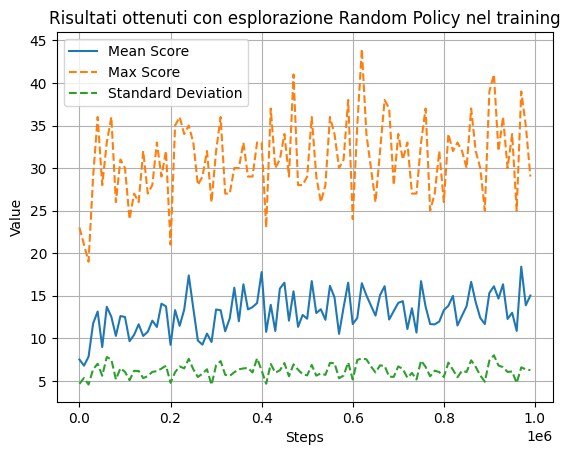

In [14]:
directory = 'Q_table/RandomPolicy'
result_random_p = policy_trend(directory, MAX_N_GAMES=100)  
plot_trand(result_random_p, "Random Policy")

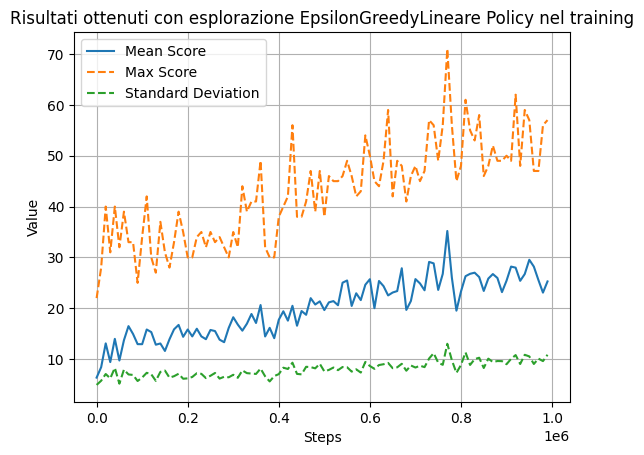

In [15]:
directory = 'Q_table/EpsilonGreedyLineare/'
EpsilonGreedyLineare_p = policy_trend(directory, MAX_N_GAMES=100)  
plot_trand(EpsilonGreedyLineare_p, "EpsilonGreedyLineare Policy")

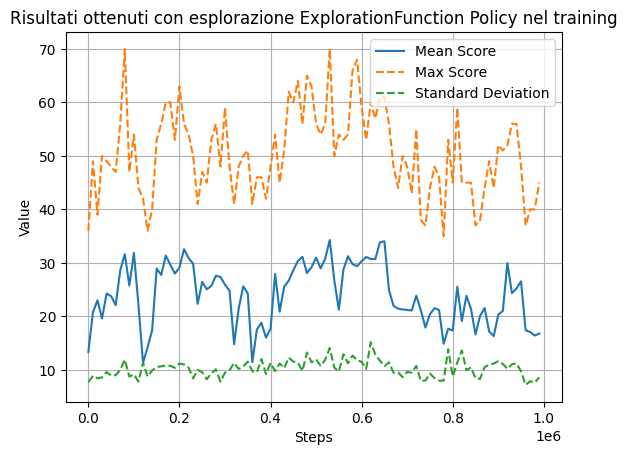

In [16]:
directory = 'Q_table/ExplorationFunction'
ExplorationFunction_p = policy_trend(directory, MAX_N_GAMES=100)  
plot_trand(ExplorationFunction_p, "ExplorationFunction Policy")

Esecuzione con visuale della policy ottimale imparata 

In [17]:
'''import enviroment as enviroment_visual
Q_table = np.load('Q_table/EpsilonGreedyLineare/1000000step.npy')
env_visual = enviroment_visual.SnakeGameAI()
env_visual.reset()
game_over = False
while not game_over:
    state= env_visual.get_state()
    row_Q_value = binary_vector_to_decimal(state)
    action = np.argmax(Q_table[row_Q_value])
    final_move = [0,0,0]
    final_move[action] = 1
    new_state, reward, game_over, score = env_visual.play_step_QL(final_move)
    
print(f"Score: {score}", end="")'''

'import enviroment as enviroment_visual\nQ_table = np.load(\'Q_table/EpsilonGreedyLineare/1000000step.npy\')\nenv_visual = enviroment_visual.SnakeGameAI()\nenv_visual.reset()\ngame_over = False\nwhile not game_over:\n    state= env_visual.get_state()\n    row_Q_value = binary_vector_to_decimal(state)\n    action = np.argmax(Q_table[row_Q_value])\n    final_move = [0,0,0]\n    final_move[action] = 1\n    new_state, reward, game_over, score = env_visual.play_step_QL(final_move)\n    \nprint(f"Score: {score}", end="")'